In [43]:
from pypdf import PdfReader

def extract_raw_text_range(pdf_path: str, start_page: int, end_page: int) -> str:
    """
    Extracts and returns the raw text from pages start_page through end_page (inclusive).
    Pages are 1-based.
    """
    reader = PdfReader(pdf_path)
    num_pages = len(reader.pages)
    # clamp to valid range
    start = max(1, start_page)
    end   = min(end_page, num_pages)
    if start > end:
        return ""
    # extract and join
    texts = [
        reader.pages[i].extract_text() or ""
        for i in range(start - 1, end)
    ]
    return "\n".join(texts)

# usage example
if __name__ == "__main__":
    pdf_file = "CRF1000 A_PC_13MJPG02_(G.H).pdf"
    text_snippet = extract_raw_text_range(pdf_file, start_page=182, end_page=182)
    print(text_snippet)


2016.09.20 E
179
2
EOP-1 GASKET KIT A
Ref.
No. Part No. Description
Reqd. QTY
Parts catalogue code           CRF1000     CRF1000A    CRF1000D
            G        H        G         H        G        H
Serial No.
1 06111-MJP-A60 GASKET KIT A ••••••••••••••••   1   1   1   1   1   1 -------- -------- 2ED,2U,3ED,3U,ED,U
12229-HL4-000 SEAL, PLUG TUBE •••••••••••••   2   2   2   2   2   2 -------- -------- 2ED,2U,3ED,3U,ED,U
12251-MJP-G51 GASKET, CYLINDER HEAD •••••••   1   1   1   1   1   1 -------- -------- 2ED,2U,3ED,3U,ED,U
12391-HL4-000 GASKET, HEAD COVER ••••••••••   1   1   1   1   1   1 -------- -------- 2ED,2U,3ED,3U,ED,U14523-HL4-003 GASKET, TENSIONER HOLE ••••••   1   1   1   1   1   1 -------- -------- 2ED,2U,3ED,3U,ED,U
18291-MM8-880 GASKET, EX. PIPE ••••••••••••   2   2   2   2   2   2 -------- -------- 2ED,2U,3ED,3U,ED,U
90442-397-000 WASHER, SEALING, 6MM ••••••••   1   1   1   1   1   1 -------- -------- 2ED,2U,3ED,3U,ED,U90543-MV9-670 RUBBER, MOUNTING ••••••••••••   3   3 

F-50 — MARK


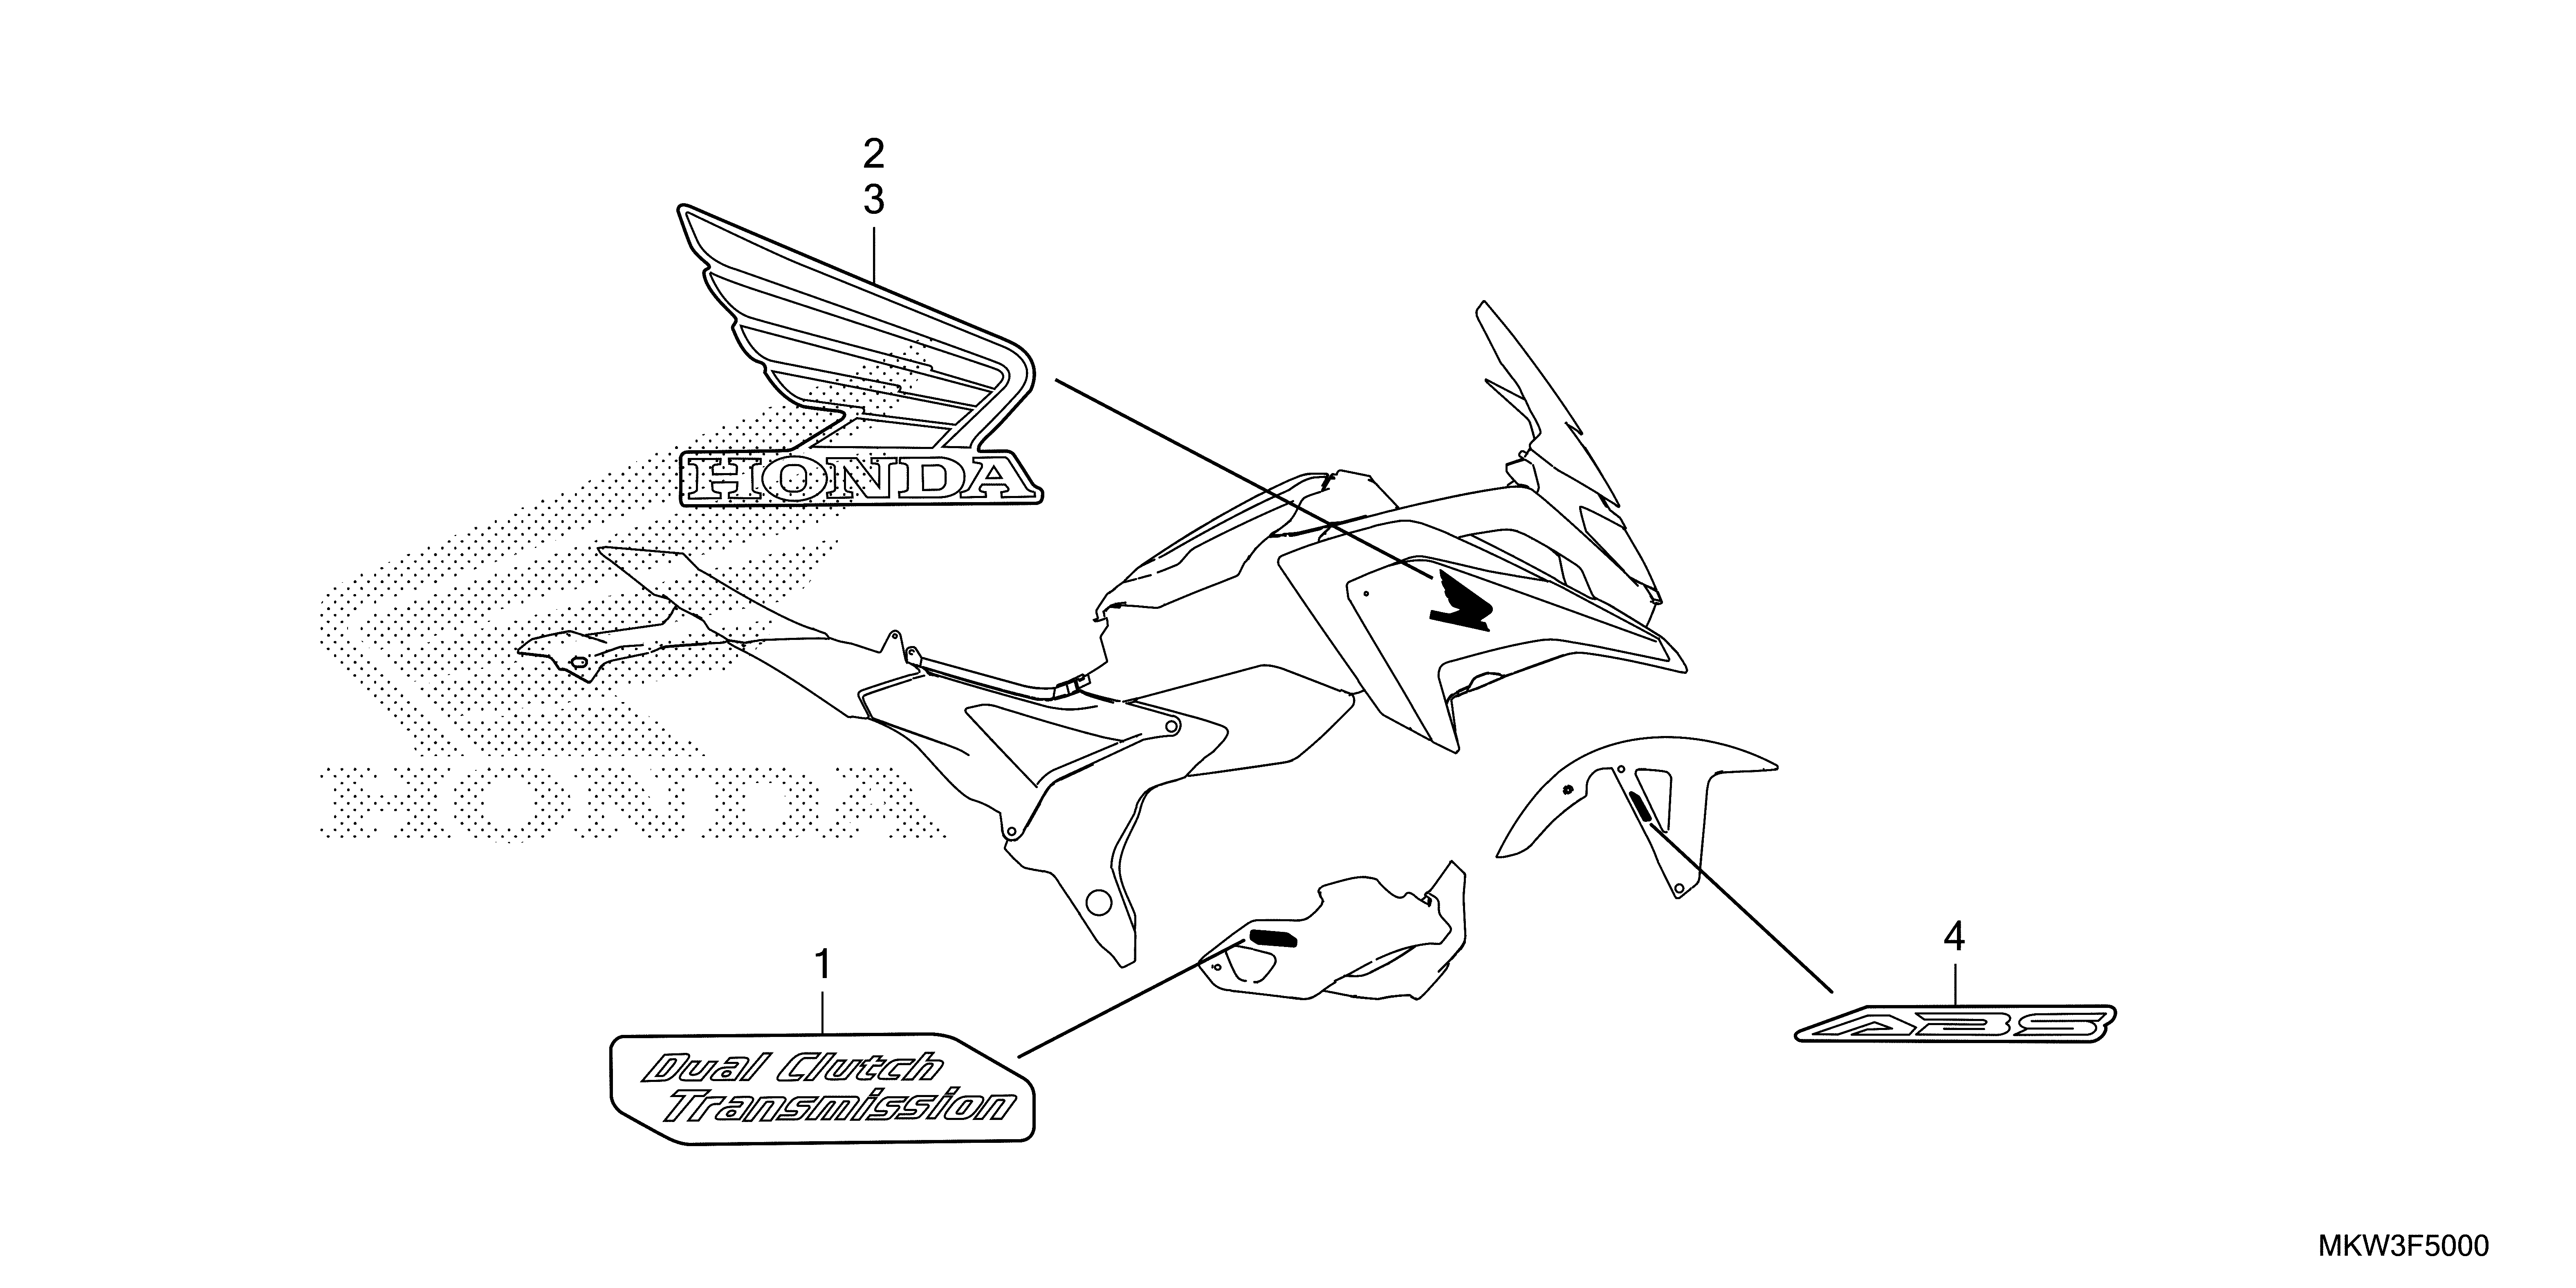

In [117]:
import re
from pypdf import PdfReader
import fitz          # PyMuPDF
import pandas as pd
from io import BytesIO
from PIL import Image, ImageOps

def extract_all_section_images(
    pdf_path: str,
    dpi: int = 150,
    filter_section: str = None
) -> pd.DataFrame:
    """
    1) Scan each page’s text for section headers like "E-2 ..." or "F-40-1 ...",
       and once started, record the very first image on each new section page.
    2) If an image has no colorspace or is 1-channel, render it then invert its bits
       via PIL so that black stays black.
    3) Otherwise, convert any non-RGB pixmap to RGB before saving.
    4) Optionally filter to a single section_num.
    """
    header_re = re.compile(r'^([A-Z]-\d+(?:-\d+)*)\b\s+(.+)$')
    reader   = PdfReader(pdf_path)
    doc_fitz = fitz.open(pdf_path)
    zoom      = dpi / 72.0

    started = False
    seen    = set()
    records = []

    for page_idx, page in enumerate(reader.pages):
        text = page.extract_text() or ""
        for ln in text.splitlines():
            ln = ln.strip()
            m = header_re.match(ln)
            if not m:
                continue

            sec_num, sec_name = m.group(1).upper(), m.group(2).strip()
            if not started:
                started = True
            if filter_section and sec_num != filter_section:
                break
            if sec_num in seen:
                break
            seen.add(sec_num)

            fz_page = doc_fitz.load_page(page_idx)
            imgs    = fz_page.get_images(full=True)
            if imgs:
                xref = imgs[0][0]
                pix  = fitz.Pixmap(doc_fitz, xref)

                # render to PNG bytes first
                buf = pix.tobytes("png")
                pix = None

                # Now if it's a 1-channel/mask or has no colorspace, PIL-invert:
                img = Image.open(BytesIO(buf))
                # if grayscale or truly mask, invert
                if img.mode in ("1","L") or img.mode=="P":
                    img = ImageOps.invert(img.convert("L"))
                    img = img.convert("RGB")
                # otherwise leave RGB as is
                out = BytesIO()
                img.save(out, format="PNG")
                png = out.getvalue()
            else:
                png = b''

            records.append({
                "section_num":  sec_num,
                "section_name": sec_name,
                "image_data":   png
            })
            break

    doc_fitz.close()
    return pd.DataFrame(records, columns=["section_num", "section_name", "image_data"])


df_e2 = extract_all_section_images(
    "NC750XAP_13MKWM02_PC_2022_2023.pdf",
    filter_section="F-50"
)

from IPython.display import display, Image as IPImage
for _, row in df_e2.iterrows():
    print(f"{row.section_num} — {row.section_name}")
    display(IPImage(data=row.image_data))



# INCASE OTHER CODES FAIL

In [5]:
import re
from pypdf import PdfReader
import pandas as pd

def extract_parts(pdf_path: str, section_code: str, section_title: str) -> pd.DataFrame:
    """
    Extract REF. NO., PART NO., DESCRIPTION from the given section,
    using inline_ref only when it's at least as long as the current_ref,
    and using a delta heuristic: when a new raw REF jumps by >1 from the
    previous, drop exactly the same number of leading digits as the previous REF—
    but if that previous REF ends in 9, always keep two digits.
    """
    reader = PdfReader(pdf_path)
    text   = "\n".join(page.extract_text() or "" for page in reader.pages)
    # normalize hyphens and linebreaks
    text   = text.replace('–','-')
    text   = re.sub(r'\r\n?','\n', text)
    text   = re.sub(r'\n+','\n', text)
    lines  = [ln.strip() for ln in text.splitlines() if ln.strip()]

    # 1) locate the section
    sec_start_re = re.compile(rf'^{re.escape(section_code)}\s+{re.escape(section_title)}', re.IGNORECASE)
    sec_stop_re  = re.compile(rf'^(?!{re.escape(section_code)}\b)[A-Z]-\d+', re.IGNORECASE)

    block, in_block = [], False
    for ln in lines:
        if not in_block:
            if sec_start_re.match(ln):
                in_block = True
            continue
        if sec_stop_re.match(ln) or 'Ref.Part' in ln:
            break
        block.append(ln)

    # 2) merge wrapped lines
    row_start = re.compile(r'^(?:\d+\s+)?\d+-[A-Za-z0-9\-]+')
    merged    = []
    for ln in block:
        if row_start.match(ln):
            merged.append(ln)
        elif merged:
            merged[-1] += ' ' + ln

    # 3) prepare regexes
    lon_re   = re.compile(r'^No\.\s*L\.O\.N\.', re.IGNORECASE)
    entry_re = re.compile(
        r'(?:^|\s)'
        r'(?:(\d+)(?=\s+\d+-)\s+)?'     # optional inline REF
        r'(\d+-[A-Za-z0-9\-]+)\s+'       # PART NO.
        r'(.*?)'                        # DESCRIPTION
        r'(?=\s*•|\s*\.{2,}|\s{2,}\d)'   # stop before bullets, dots, or qty
    )

    current_ref = None
    prev_ref_i  = None
    records     = []

    for ln in merged:
        if lon_re.match(ln) or 'Ref.Part' in ln:
            continue

        # pick up the leading REF and apply delta‐collapse
        m0 = re.match(r'^(?P<ref>\d+)\s+(?=\d+-)', ln)
        if m0:
            raw   = m0.group('ref')
            raw_i = int(raw)

            # normally strip prev_digits = len(str(prev_ref_i)), but
            # if prev_ref_i ends in 9, force prev_digits = 2
            if prev_ref_i is not None and prev_ref_i % 10 == 9:
                prev_digits = 2
            else:
                prev_digits = len(str(prev_ref_i)) if prev_ref_i is not None else 1

            if prev_ref_i is not None and (raw_i - prev_ref_i) > 1:
                # drop that many leading digits
                current_ref = raw[-prev_digits:]
            else:
                # usual: keep up to two digits
                current_ref = raw if len(raw) <= 2 else raw[-2:]
            prev_ref_i = int(current_ref)

        # now extract parts on this line
        for inline_ref, part_no, raw_desc in entry_re.findall(ln):
            if inline_ref:
                ir_i = int(inline_ref)
                if prev_ref_i is not None and prev_ref_i % 10 == 9:
                    prev_digits = 2
                else:
                    prev_digits = len(str(prev_ref_i)) if prev_ref_i is not None else 1

                if prev_ref_i is not None and (ir_i - prev_ref_i) > 1:
                    new_ref = inline_ref[-prev_digits:]
                else:
                    new_ref = inline_ref if len(inline_ref) <= 2 else inline_ref[-2:]
                if current_ref is None or len(new_ref) >= len(str(current_ref)):
                    current_ref = new_ref
                prev_ref_i   = int(current_ref)

            # clean description, strip stray U+F020
            desc = (raw_desc
                    .replace('•','')
                    .replace('\uFEFF','')
                    .replace('\uf020','')
                    .strip())
            desc = re.sub(r'\s+', ' ', desc)
            desc = re.sub(r'\s+\d+(?:\s+\d+)*$', '', desc)
            desc = re.sub(r'(-+\s*)+$', '', desc).strip()

            records.append({
                "REF. NO.":    current_ref,
                "PART NO.":    part_no,
                "DESCRIPTION": desc
            })

    return pd.DataFrame(records, columns=["REF. NO.", "PART NO.", "DESCRIPTION"])


# example for E-3 CAMSHAFT/VALVE  
df = extract_parts(
    "CRF1000 A_PC_13MJPG02_(G.H).pdf",
    section_code="F-40-2",
    section_title="MARK/EMBLEM(CRF COLOR)"
)
print(df.head(40))


   REF. NO.         PART NO.                       DESCRIPTION
0         1  86101-MJP-G50ZA         MARK, HONDA(65MM) *TYPE1*
1         2  86102-MJP-G50ZA         MARK, HONDA(55MM) *TYPE1*
2         3  86171-MJP-F50ZA    STRIPE A, R. FUEL TANK *TYPE1*
3         4  86172-MJP-F50ZA    STRIPE A, L. FUEL TANK *TYPE1*
4         5  86173-MJP-F50ZA    STRIPE B, R. FUEL TANK *TYPE1*
5         6  86174-MJP-F50ZA    STRIPE B, L. FUEL TANK *TYPE1*
6         7    86211-MJP-G50                 BADGE, R. PRODUCT
7         8    86212-MJP-G50                 BADGE, L. PRODUCT
8         9  86611-MJP-F50ZA     STRIPE, R. FR. FENDER *TYPE1*
9        10  86612-MJP-F50ZA     STRIPE, L. FR. FENDER *TYPE1*
10       11  86641-MJP-F50ZA  STRIPE A, R. MIDDLE COWL *TYPE1*
11       12  86642-MJP-F50ZA  STRIPE A, L. MIDDLE COWL *TYPE1*
12       13  86643-MJP-F50ZA  STRIPE B, R. MIDDLE COWL *TYPE1*
13       14  86644-MJP-F50ZA  STRIPE B, L. MIDDLE COWL *TYPE1*
14       15  86831-MJP-G50ZA       MARK, R. SIDE COVER 

In [ ]:
import re
from pypdf import PdfReader
import pandas as pd

def extract_parts(pdf_path: str, section_code: str, section_title: str) -> pd.DataFrame:
    
    reader = PdfReader(pdf_path)
    text   = "\n".join(page.extract_text() or "" for page in reader.pages)
    # normalize hyphens and linebreaks
    text   = text.replace('–','-')
    text   = re.sub(r'\r\n?','\n', text)
    text   = re.sub(r'\n+','\n', text)
    lines  = [ln.strip() for ln in text.splitlines() if ln.strip()]

    # 1) locate the section
    sec_start_re = re.compile(
        rf'^{re.escape(section_code)}\s+{re.escape(section_title)}',
        re.IGNORECASE
    )
    sec_stop_re  = re.compile(
        rf'^(?!{re.escape(section_code)}\b)[A-Z]-\d+',
        re.IGNORECASE
    )

    block, in_block = [], False
    for ln in lines:
        if not in_block:
            if sec_start_re.match(ln):
                in_block = True
            continue
        if sec_stop_re.match(ln) or 'Ref.Part' in ln:
            break
        block.append(ln)

    # 2) merge wrapped lines
    row_start = re.compile(r'^(?:\d+\s+)?\d+-[A-Za-z0-9\-]+')
    merged    = []
    for ln in block:
        if row_start.match(ln):
            merged.append(ln)
        elif merged:
            merged[-1] += ' ' + ln

    # 3) prepare regexes
    lon_re   = re.compile(r'^No\.\s*L\.O\.N\.', re.IGNORECASE)
    entry_re = re.compile(r"""
        (?:^|\s)
        (?:(\d+)(?=\s+\d+-)\s+)?       # optional inline REF
        (\d+-[A-Za-z0-9\-]+)\s+        # PART NO.
        (.*?)                          # DESCRIPTION
        (?=                            # stop before:
            \s{2,}\d                   |   # two-or-more spaces + digit (the real qty)
            (?<!,)\s\d                 |   # single-space+digit only if NOT preceded by comma
            \s*[•∙]                    |   # bullet characters
            \s*\.{2,}                      # runs of dots
        )
    """, re.VERBOSE)

    current_ref = None
    prev_ref_i  = None
    records     = []

    for ln in merged:
        if lon_re.match(ln) or 'Ref.Part' in ln:
            continue

        # pick up the leading REF and apply delta-collapse
        m0 = re.match(r'^(?P<ref>\d+)\s+(?=\d+-)', ln)
        if m0:
            raw   = m0.group('ref')
            raw_i = int(raw)

            if prev_ref_i is not None and prev_ref_i % 10 == 9:
                prev_digits = 2
            else:
                prev_digits = len(str(prev_ref_i)) if prev_ref_i is not None else 1

            if prev_ref_i is not None and (raw_i - prev_ref_i) > 1:
                current_ref = raw[-prev_digits:]
            else:
                current_ref = raw if len(raw) <= 2 else raw[-2:]
            prev_ref_i = int(current_ref)

        # now extract each part on this line
        for inline_ref, part_no, raw_desc in entry_re.findall(ln):
            if inline_ref:
                ir_i = int(inline_ref)
                if prev_ref_i is not None and prev_ref_i % 10 == 9:
                    prev_digits = 2
                else:
                    prev_digits = len(str(prev_ref_i)) if prev_ref_i is not None else 1

                if prev_ref_i is not None and (ir_i - prev_ref_i) > 1:
                    new_ref = inline_ref[-prev_digits:]
                else:
                    new_ref = inline_ref if len(inline_ref) <= 2 else inline_ref[-2:]

                if current_ref is None or len(new_ref) >= len(str(current_ref)):
                    current_ref = new_ref
                prev_ref_i = int(current_ref)

            # clean description
            desc = (raw_desc
                    .replace('•','')
                    .replace('∙','')
                    .replace('\uFEFF','')
                    .replace('\uf020','')
                    .strip())
            desc = re.sub(r'\s+', ' ', desc)
            desc = re.sub(r'\s+\d+(?:\s+\d+)*$', '', desc)
            desc = re.sub(r'(-+\s*)+$', '', desc).strip()

            records.append({
                "REF. NO.":    current_ref,
                "PART NO.":    part_no,
                "DESCRIPTION": desc
            })

    return pd.DataFrame(records, columns=["REF. NO.", "PART NO.", "DESCRIPTION"])


# — example usage for E-1 CYLINDER HEAD COVER —
if __name__ == "__main__":
    df = extract_parts(
        "NC750XAP_13MKWM02_PC_2022_2023.pdf",
        section_code="E-2",
        section_title="CYLINDER HEAD"
    )
    print(df.head(30))


# NO ERROR CODE WORKS FINE FOR TEST PDF

In [3]:
import re
from pypdf import PdfReader
import pandas as pd

def extract_parts_from_lines(
    lines: list[str],
    section_code: str,
    section_title: str
) -> pd.DataFrame:
    """
    Exactly your original extract_parts logic, but operating on
    a precomputed `lines` list rather than re-reading the PDF.
    """
    sec_start_re = re.compile(
        rf'^{re.escape(section_code)}\s+{re.escape(section_title)}',
        re.IGNORECASE
    )
    sec_stop_re  = re.compile(
        rf'^(?!{re.escape(section_code)}\b)[A-Z]-\d+',
        re.IGNORECASE
    )

    # 1) slice out the block
    block, in_block = [], False
    for ln in lines:
        if not in_block:
            if sec_start_re.match(ln):
                in_block = True
            continue
        if sec_stop_re.match(ln) or 'Ref.Part' in ln:
            break
        block.append(ln)

    # 2) merge wrap-lines
    row_start = re.compile(r'^(?:\d+\s+)?\d+-[A-Za-z0-9\-]+')
    merged    = []
    for ln in block:
        if row_start.match(ln):
            merged.append(ln)
        elif merged:
            merged[-1] += ' ' + ln

    # 3) prepare regexes & extract rows
    lon_re   = re.compile(r'^No\.\s*L\.O\.N\.', re.IGNORECASE)
    entry_re = re.compile(
        r'(?:^|\s)'
        r'(?:(\d+)(?=\s+\d+-)\s+)?'    # optional inline REF
        r'(\d+-[A-Za-z0-9\-]+)\s+'      # PART NO.
        r'(.*?)'                       # DESCRIPTION
        r'(?=\s*•|\s*\.{2,}|\s{2,}\d)'  # stop before qty/dots/bullets
    )

    current_ref = None
    prev_ref_i  = None
    records     = []
    for ln in merged:
        if lon_re.match(ln) or 'Ref.Part' in ln:
            continue

        # leading REF
        m0 = re.match(r'^(?P<ref>\d+)\s+(?=\d+-)', ln)
        if m0:
            raw   = m0.group('ref')
            raw_i = int(raw)
            if prev_ref_i is not None and prev_ref_i % 10 == 9:
                prev_digits = 2
            else:
                prev_digits = len(str(prev_ref_i)) if prev_ref_i is not None else 1

            if prev_ref_i is not None and (raw_i - prev_ref_i) > 1:
                current_ref = raw[-prev_digits:]
            else:
                current_ref = raw if len(raw) <= 2 else raw[-2:]
            prev_ref_i = int(current_ref)

        # inline entries
        for inline_ref, part_no, raw_desc in entry_re.findall(ln):
            if inline_ref:
                ir_i = int(inline_ref)
                if prev_ref_i is not None and prev_ref_i % 10 == 9:
                    prev_digits = 2
                else:
                    prev_digits = len(str(prev_ref_i)) if prev_ref_i is not None else 1

                if prev_ref_i is not None and (ir_i - prev_ref_i) > 1:
                    new_ref = inline_ref[-prev_digits:]
                else:
                    new_ref = inline_ref if len(inline_ref) <= 2 else inline_ref[-2:]
                if current_ref is None or len(new_ref) >= len(str(current_ref)):
                    current_ref = new_ref
                prev_ref_i = int(current_ref)

            desc = (raw_desc
                    .replace('•','')
                    .replace('\uFEFF','')
                    .replace('\uf020','')
                    .strip())
            desc = re.sub(r'\s+', ' ', desc)
            desc = re.sub(r'\s+\d+(?:\s+\d+)*$', '', desc)
            desc = re.sub(r'(-+\s*)+$', '', desc).strip()

            records.append({
                "REF. NO.":    current_ref,
                "PART NO.":    part_no,
                "DESCRIPTION": desc
            })

    return pd.DataFrame(records, columns=["REF. NO.", "PART NO.", "DESCRIPTION"])


def extract_all(pdf_path: str) -> pd.DataFrame:
    """
    1. Read & normalize the PDF *once*.
    2. Find all section headers.
    3. Call extract_parts_from_lines() on each.
    4. Concatenate & tag with section_no and component_name.
    """
    reader = PdfReader(pdf_path)
    text   = "\n".join(page.extract_text() or "" for page in reader.pages)
    text   = text.replace('–','-')
    text   = re.sub(r'\r\n?','\n', text)
    text   = re.sub(r'\n+','\n', text)
    lines  = [ln.strip() for ln in text.splitlines() if ln.strip()]

    # detect headers like "E-2 CYLINDER HEAD" or "F-40-2 MARK/EMBLEM"
    header_re = re.compile(r'^([A-Z]-\d+(?:-\d+)*)\s+(.+)$')
    sections  = []
    for ln in lines:
        m = header_re.match(ln)
        if m:
            sections.append(m.groups())

    all_dfs = []
    for code, title in sections:
        df = extract_parts_from_lines(lines, code, title)
        df["section_no"]     = code
        df["component_name"] = title
        all_dfs.append(df)

    return pd.concat(all_dfs, ignore_index=True)[
        ["section_no","component_name","REF. NO.","PART NO.","DESCRIPTION"]
    ]


# — run & export —
df_all = extract_all("CRF1000 A_PC_13MJPG02_(G.H).pdf")
#df_all.to_csv("all_parts.csv", index=False)
print(df_all.head(20))


   section_no       component_name REF. NO.       PART NO.  \
0         E-1  CYLINDER HEAD COVER        1  12229-HL4-000   
1         E-1  CYLINDER HEAD COVER        2  12300-MJP-G50   
2         E-1  CYLINDER HEAD COVER        3  12341-MAT-750   
3         E-1  CYLINDER HEAD COVER        4  12391-HL4-000   
4         E-1  CYLINDER HEAD COVER        5  18601-KEA-741   
5         E-1  CYLINDER HEAD COVER        6  18612-MJP-G50   
6         E-1  CYLINDER HEAD COVER        7  90004-GHB-640   
7         E-1  CYLINDER HEAD COVER        8  90017-MAL-600   
8         E-1  CYLINDER HEAD COVER        9  90543-MV9-670   
9         E-1  CYLINDER HEAD COVER       10    94301-10160   
10        E-2        CYLINDER HEAD        1  12010-MJP-G50   
11        E-2        CYLINDER HEAD        2  12204-HL4-305   
12        E-2        CYLINDER HEAD        3  12205-HL4-305   
13        E-2        CYLINDER HEAD        4  12251-MJP-G51   
14        E-2        CYLINDER HEAD        5  16211-MJP-G50   
15      

In [1]:
import re
from pypdf import PdfReader
import pandas as pd

def extract_parts_from_lines(
    lines: list[str],
    section_code: str,
    section_title: str
) -> pd.DataFrame:
    sec_start_re = re.compile(
        rf'^{re.escape(section_code)}\s+{re.escape(section_title)}',
        re.IGNORECASE
    )
    sec_stop_re  = re.compile(
        rf'^(?!{re.escape(section_code)}\b)[A-Z]-\d+',
        re.IGNORECASE
    )

    block, in_block = [], False
    for ln in lines:
        if not in_block:
            if sec_start_re.match(ln):
                in_block = True
            continue
        if sec_stop_re.match(ln) or 'Ref.Part' in ln:
            break
        block.append(ln)

    row_start = re.compile(r'^(?:\d+\s+)?\d+-[A-Za-z0-9\-]+')
    merged    = []
    for ln in block:
        if row_start.match(ln):
            merged.append(ln)
        elif merged:
            merged[-1] += ' ' + ln

    lon_re   = re.compile(r'^No\.\s*L\.O\.N\.', re.IGNORECASE)
    entry_re = re.compile(r"""
        (?:^|\s)
        (?:(\d+)(?=\s+\d+-)\s+)?       # optional inline REF
        (\d+-[A-Za-z0-9\-]+)\s+        # PART NO.
        (.*?)                          # DESCRIPTION
        (?=                            # stop before:
            \s{2,}\d                   |   # two-or-more spaces + digit (qty)
            (?<!,)\s\d                 |   # single-space+digit not after comma
            \s*[•∙]                    |   # bullet characters
            \s*\.{2,}                      # runs of dots
        )
    """, re.VERBOSE)

    current_ref = None
    prev_ref_i  = None
    records     = []

    for ln in merged:
        if lon_re.match(ln) or 'Ref.Part' in ln:
            continue

        m0 = re.match(r'^(?P<ref>\d+)\s+(?=\d+-)', ln)
        if m0:
            raw   = m0.group('ref')
            raw_i = int(raw)
            if prev_ref_i is not None and prev_ref_i % 10 == 9:
                pdig = 2
            else:
                pdig = len(str(prev_ref_i)) if prev_ref_i is not None else 1

            if prev_ref_i is not None and (raw_i - prev_ref_i) > 1:
                current_ref = raw[-pdig:]
            else:
                current_ref = raw if len(raw) <= 2 else raw[-2:]
            prev_ref_i = int(current_ref)

        for inline_ref, part_no, raw_desc in entry_re.findall(ln):
            if inline_ref:
                ir_i = int(inline_ref)
                if prev_ref_i is not None and prev_ref_i % 10 == 9:
                    pdig = 2
                else:
                    pdig = len(str(prev_ref_i)) if prev_ref_i is not None else 1

                if prev_ref_i is not None and (ir_i - prev_ref_i) > 1:
                    new_ref = inline_ref[-pdig:]
                else:
                    new_ref = inline_ref if len(inline_ref) <= 2 else inline_ref[-2:]

                if current_ref is None or len(new_ref) >= len(str(current_ref)):
                    current_ref = new_ref
                prev_ref_i = int(current_ref)

            desc = (raw_desc
                    .replace('•','')
                    .replace('∙','')
                    .replace('\uFEFF','')
                    .replace('\uf020','')
                    .strip())
            desc = re.sub(r'\s+', ' ', desc)
            desc = re.sub(r'\s+\d+(?:\s+\d+)*$', '', desc)
            desc = re.sub(r'(-+\s*)+$', '', desc).strip()

            records.append({
                "ref_no":    current_ref,
                "part_no":    part_no,
                "description": desc
            })

    return pd.DataFrame(records, columns=["ref_no", "part_no", "description"])


def extract_all(pdf_path: str) -> pd.DataFrame:
    reader   = PdfReader(pdf_path)
    raw_text = "\n".join(page.extract_text() or "" for page in reader.pages)
    text     = raw_text.replace('–','-')
    text     = re.sub(r'\r\n?','\n',   text)
    text     = re.sub(r'\n+','\n',     text)
    lines    = [ln.strip() for ln in text.splitlines() if ln.strip()]

    header_re   = re.compile(r'^([A-Z]+-\d+(?:-\d+)*)\s+(.+)$')
    sections    = [(m.group(1), m.group(2))
                   for ln in lines if (m := header_re.match(ln))]

    all_dfs     = []
    seen_codes  = set()
    for code, title in sections:
        if code in seen_codes:
            continue                 # skip any repeated section
        seen_codes.add(code)

        df = extract_parts_from_lines(lines, code, title)
        if not df.empty:
            df["section"]     = code
            df["component_name"] = title
            all_dfs.append(df)

    if not all_dfs:
        return pd.DataFrame(
            columns=["section","component_name","ref_no", "part_no", "description"]
        )

    return pd.concat(all_dfs, ignore_index=True)[
        ["section","component_name","ref_no", "part_no", "description"]
    ]


if __name__ == "__main__":
    df_all = extract_all("NC750XAP_13MKWM02_PC_2022_2023.pdf")
    df_all.to_csv("all_parts.csv", index=False)
    print(df_all.tail(20))


     section component_name ref_no          part_no  \
1898    F-49  CAUTION LABEL     14    87586-MGC-DD0   
1899    F-49  CAUTION LABEL     15    87593-MKA-S80   
1900    F-49  CAUTION LABEL     16    87700-KVG-901   
1901    F-50           MARK      1    11378-MKS-E50   
1902    F-50           MARK      2  86201-MKA-A30ZB   
1903    F-50           MARK      2  86201-MKW-D00ZC   
1904    F-50           MARK      2  86201-MKW-D00ZB   
1905    F-50           MARK      2  86201-MKW-D00ZA   
1906    F-50           MARK      2  86201-MKW-D20ZB   
1907    F-50           MARK      2  86201-MKW-D20ZC   
1908    F-50           MARK      2  86201-MKW-D20ZA   
1909    F-50           MARK      3  86202-MKA-A30ZB   
1910    F-50           MARK      3  86202-MKW-D00ZC   
1911    F-50           MARK      3  86202-MKW-D00ZB   
1912    F-50           MARK      3  86202-MKW-D00ZA   
1913    F-50           MARK      3  86202-MKW-D20ZB   
1914    F-50           MARK      3  86202-MKW-D20ZC   
1915    F-